# Limpieza, preparación y análisis de los datos 

En este notebook estará todo lo relaciona con la limpieza, preparación y análisis del corpus de noticias verdaderas y falsas sobre política en Colombia.

In [ ]:
!pip install nltk
!pip install WordCloud
!pip install plotly
!pip install gensim

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 366 kB 20.6 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 24.1 MB 27.9 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


Importamos las librerías&nbsp;para&nbsp;la&nbsp;limpieza,&nbsp;exploración&nbsp;y&nbsp;análisis&nbsp;de&nbsp;los&nbsp;datos&nbsp;del&nbsp;corpus

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import plotly.express as px
import gensim
import collections
import pickle

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from gensim.utils import simple_preprocess
from wordcloud import WordCloud, STOPWORDS
from gensim.parsing.preprocessing import STOPWORDS
from wordcloud import WordCloud, STOPWORDS

nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#Cargamos los datos de nuestro corpus, el cual su separador es ‘;’
co = pd.read_csv('corpus.csv', sep=';')
co

,ID,TITULO,CUERPO,TEMA,FECHA PUBLICACION,URL,EDITORIAL,ETIQUETA,Unnamed: 8,Unnamed: 9
0,1.0,"Viéndonos, Petro y Uribe debe estar muertos de...","Humberto de la Calle, actual cabeza de lista a...",Partidos politicos,31/1/2022,https://www.eltiempo.com/politica/partidos-pol...,El tiempo,Verdadera,NaN,NaN
1,2.0,Ingrid Betancourt se postula a la presidencia ...,"Ingrid Betancourt, excongresista y quien fue m...",Presidencia de Colombia,18/1/2022,https://www.nytimes.com/es/2022/01/18/espanol/...,New York Times,Verdadera,NaN,NaN
2,3.0,Chile como espejo político de Colombia en 2022,"Ni Duque es Piñera, ni Petro es Boric y no ten...",Presidencia de Colombia,10/1/2022,https://www.elespectador.com/opinion/columnist...,El Espectador,Verdadera,NaN,NaN
3,4.0,Presidente Iván Duque confirmó que habló con Z...,"Recientemente, el candidato a la Presidencia Ó...",Partidos politicos,31/1/2022,https://www.semana.com/nacion/articulo/preside...,Semana,Verdadera,NaN,NaN
4,5.0,¿Qué cambia con la Ley de Seguridad Ciudadana ...,El presidente Iván Duque sancionó en la noche ...,Seguridad nacional,26/1/2022,https://www.eltiempo.com/politica/gobierno/ley...,El tiempo,Verdadera,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Limpieza de datos

Eliminación de datos nulos o vacíos

In [ ]:
#Ver si hay datos en la tabla que son nulos
print("Hay", co["ID"].isnull().sum(), "datos que son nulos")

Hay 770 datos que son nulos


In [ ]:
#Procedemos a eliminar todos los datos nulos del corpus
co = co.dropna(subset=["ID"])

Eliminación de columnas que no son relevantes para entrenar nuestros modelos

In [ ]:
co = co.drop(["ID", "TEMA", "FECHA PUBLICACION", "URL", "EDITORIAL", "Unnamed: 8"], axis=1)

Eliminación de datos repetidos

In [ ]:
#Creamos una nueva columna para ver si hay noticias con el mismo título y cuerpo
co["NOTICIA_COMPLETA"] = co["TITULO"] + ' ' + co["CUERPO"]

In [ ]:
#Vemos cuantas filas tienen el mismo titulo y cuantas filas tienen el mismo cuerpo
print("Cantidad de filas repetidas:", co.duplicated(subset='NOTICIA_COMPLETA').sum())

Cantidad de filas repetidas: 1


In [ ]:
co = co.drop_duplicates(subset='NOTICIA_COMPLETA')
print("Cantidad de filas repetidas:", co.duplicated(subset='NOTICIA_COMPLETA').sum())

Cantidad de filas repetidas: 0


Al finalizar la limpieza nuestro corpus queda de la siguiente manera

In [ ]:
co

,TITULO,CUERPO,ETIQUETA,Unnamed: 9,NOTICIA_COMPLETA
0,"Viéndonos, Petro y Uribe debe estar muertos de...","Humberto de la Calle, actual cabeza de lista a...",Verdadera,NaN,"Viéndonos, Petro y Uribe debe estar muertos de..."
1,Ingrid Betancourt se postula a la presidencia ...,"Ingrid Betancourt, excongresista y quien fue m...",Verdadera,NaN,Ingrid Betancourt se postula a la presidencia ...
2,Chile como espejo político de Colombia en 2022,"Ni Duque es Piñera, ni Petro es Boric y no ten...",Verdadera,NaN,Chile como espejo político de Colombia en 2022...
3,Presidente Iván Duque confirmó que habló con Z...,"Recientemente, el candidato a la Presidencia Ó...",Verdadera,NaN,Presidente Iván Duque confirmó que habló con Z...
4,¿Qué cambia con la Ley de Seguridad Ciudadana ...,El presidente Iván Duque sancionó en la noche ...,Verdadera,NaN,¿Qué cambia con la Ley de Seguridad Ciudadana ...
...,...,...,...,...,...
215,GUSTAVO PETRO AFIRMA SER DIOS,"En una entrevista reciente , se le preguntó al...",Falso,NaN,GUSTAVO PETRO AFIRMA SER DIOS En una entrevist...
216,"Aparecieron las llaves, el registrador en el f...",ahora entienden por qué sólo aparecen votos pa...,Falso,NaN,"Aparecieron las llaves, el registrador en el f..."
217,Presidente Iván Duque pide unidad ante fallo d...,Aunque esta vez no está en riesgo San Andrés n...,Verdadera,NaN,Presidente Iván Duque pide unidad ante fallo d...
218,Duque dice que Colombia está lista para aument...,Colombia está lista para desempeñar un papel c...,Verdadera,NaN,Duque dice que Colombia está lista para aument...


## Preparación de datos

Ahora vamos a pasar las columnas categóricas a numéricas, las noticias verdaderas tienen como etiqueta el "1" y las falsas tienen como etiqueta el "0"

In [ ]:
co = pd.get_dummies(co, columns=['ETIQUETA'], drop_first=True)

Al momento de cambiar los datos categóricos a numéricos el nombre de la columna "ETIQUETA" cambia, por eso la vamos a renombrar con su nombre original

In [ ]:
co = co.rename(columns={'ETIQUETA_Verdadera': 'ETIQUETA'})

Vamos a eliminar “stopwords” ya que son palabras que no son relevantes para entrenar nuestros modelos ya que no aportan ningún significado

In [ ]:
#Importamos algunas stopwords en español y agregamos otras
stop_words = stopwords.words("spanish")
stop_words.extend(["luego", "través", "además", "según", "pues", "sino", "mientras", "unas",
                    "alguien", "usted", "cómo", "como", "cosa", "así", "ser"])

In [ ]:
#Algoritmo que remueve “stopwords” y palabras que tienen menos de dos letras
#Algoritmo sacado del notebook llamado FakeNewsClassification
#Link del repositorio: https://github.com/andresaristi/fakenewscourseraguidedproject
def eliminar_stop_words(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)
            
    return result

In [ ]:
#Creamos una nueva columna donde se almacenen el texto sin las “stopwords”
co['NOTICIA_LIMPIA'] = co['NOTICIA_COMPLETA'].apply(eliminar_stop_words)
print(co['NOTICIA_LIMPIA'][39])

['farc', 'eln', 'apoyan', 'petro', 'disidencias', 'farc', 'eln', 'venezuela', 'planearon', 'operación', 'despedida', 'iván', 'duque', 'generar', 'ataques', 'fuerza', 'pública', 'población', 'civil', 'generar', 'miedo', 'país', 'nadie', 'secreto', 'éstos', 'grupos', 'terroristas', 'quieres', 'desestabilizar', 'país', 'paso', 'hacerle', 'campaña', 'hampón', 'petro']


In [ ]:
#Debido a que el método de “eliminar_stop_words” nos devuelve un arreglo de palabras,
#las vamos a juntar en otra columna llamada “NOTICIA”
co['NOTICIA'] = co['NOTICIA_LIMPIA'].apply(lambda x: " ".join(x))
print(co['NOTICIA'][39])

farc eln apoyan petro disidencias farc eln venezuela planearon operación despedida iván duque generar ataques fuerza pública población civil generar miedo país nadie secreto éstos grupos terroristas quieres desestabilizar país paso hacerle campaña hampón petro


## Análisis de datos

Vemos a ver la cantidad de palabras sin repetir que tenemos en nuestro corpus y cual es la cantidad de palabras de la noticia más larga


In [ ]:
#Obtiene el total de palabra presentes en el corpus
#Algoritmo sacado del notebook llamado FakeNewsClassification
#Link del repositorio: https://github.com/andresaristi/fakenewscourseraguidedproject
def total_palabras(lista_noticias):
    list_of_words = []
    for i in lista_noticias:
        for j in i:
            list_of_words.append(j)
    return list_of_words

In [ ]:
list_of_words = total_palabras(co.NOTICIA_LIMPIA)
total_words = len(list(set(list_of_words)))
print("Cantidad de palabras en el corpus:", len(list_of_words))
print("Cantidad de palabras sin repetir en el corpus:", total_words)

Cantidad de palabras en el corpus: 46518
Cantidad de palabras sin repetir en el corpus: 10734


In [ ]:
def noticia_mas_larga(lista_noticias):    
    maxlen = []
    for noticia in lista_noticias:
        # tokens = nltk.word_tokenize(doc)
        if(len(maxlen)<len(noticia)):
            maxlen = noticia
    return maxlen

In [ ]:
maxlen = len(noticia_mas_larga(co.NOTICIA_LIMPIA))
print("Cantidad de palabras de la noticia más larga:", maxlen)

Cantidad de palabras de la noticia más larga: 1219


Comparación de cantidad de noticias falsas y verdaderas

<AxesSubplot:title={'center':'Cantidad de noticias falsas y verdaderas del corpus'}, xlabel='ETIQUETA', ylabel='count'>

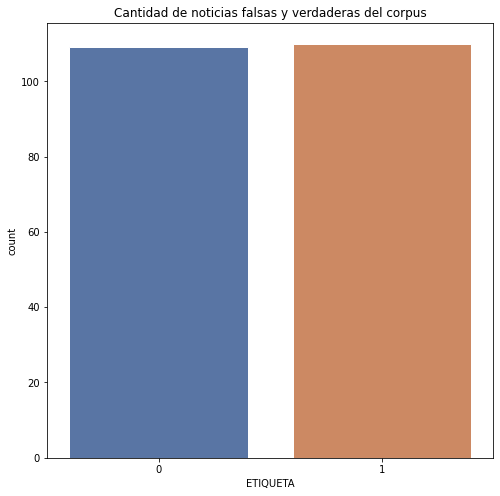

In [ ]:
plt.figure(figsize = (8, 8))
plt.title('Cantidad de noticias falsas y verdaderas del corpus')
plt.xlabel('Intensidad de entrada.')
plt.ylabel('Cantidad')
sns.set_theme(style="darkgrid")
sns.countplot(x = "ETIQUETA", data = co)

Nube de palabras más repetidas en las noticias verdaderas y falsas

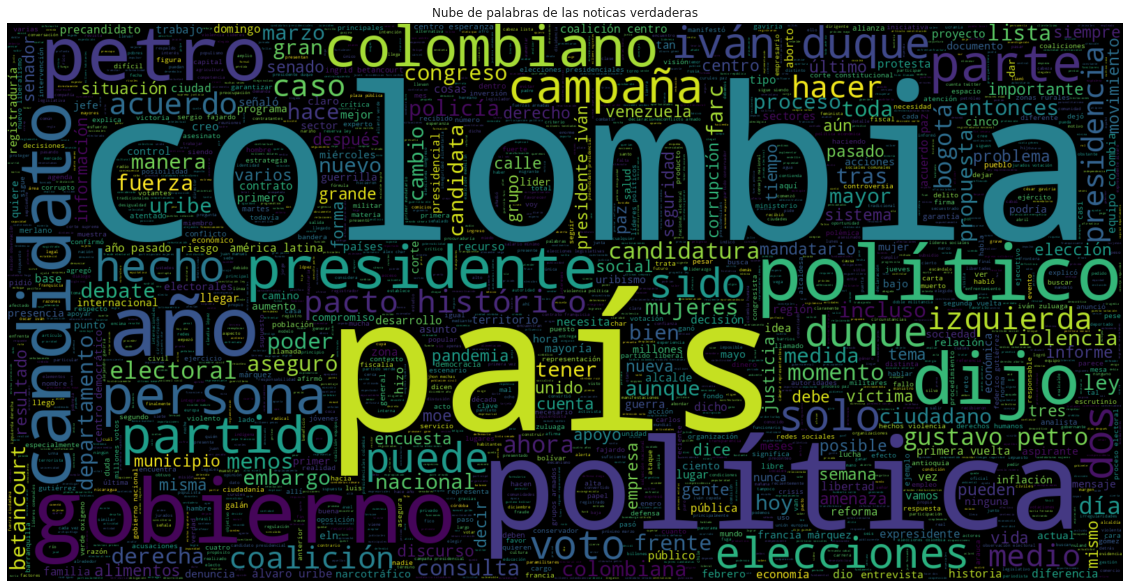

In [ ]:
plt.figure(figsize = (20,20)) 
plt.title('Nube de palabras de las noticas verdaderas')
plt.axis('off')
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(co[co.ETIQUETA == 1].NOTICIA))
plt.imshow(wc, interpolation = 'bilinear')

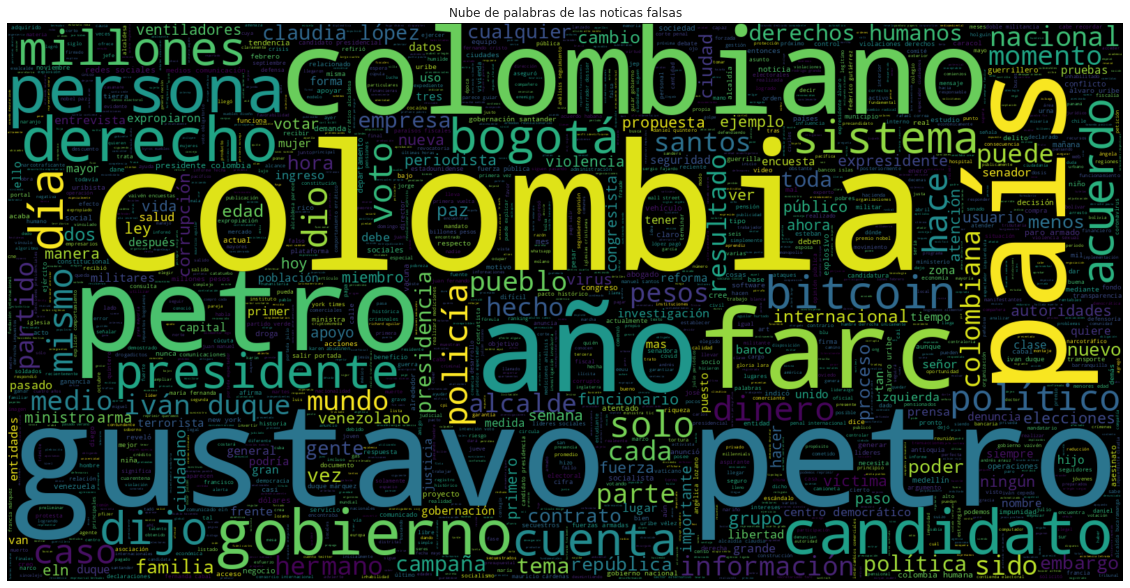

In [ ]:
plt.figure(figsize = (20,20)) 
plt.title('Nube de palabras de las noticas falsas')
plt.axis('off')
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(co[co.ETIQUETA == 0].NOTICIA))
plt.imshow(wc, interpolation = 'bilinear')

Media de número de letras por tamaño de documento

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


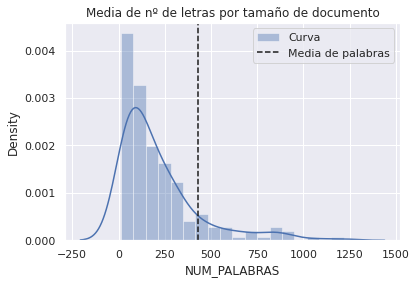

Media de palabras:  429


In [ ]:
co['NUM_PALABRAS'] = co['NOTICIA'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(co['NUM_PALABRAS'].mean() + co['NUM_PALABRAS'].std()).astype(int)
sns.distplot(co['NUM_PALABRAS'], hist=True, kde=True, color='b', label='Curva')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='Media de palabras')
plt.title('Media de nº de letras por tamaño de documento'); plt.legend()
plt.show()
print("Media de palabras: ",max_seq_len)

Exportamos el corpus y el arreglo de stop_words para que los otros notebooks lo puedan importar y usar


In [ ]:
with open("corpus_preparado.pkl", "wb") as corpus:
    pickle.dump(co, corpus)

In [ ]:
with open("stop_words.pkl", "wb") as stopWords:
    pickle.dump(stop_words, stopWords)

In [ ]:
with open("num_words.pkl", "wb") as nm:
    pickle.dump(total_words, nm)

In [ ]:
# def get_ngrams(list_with_tokens,index,n):
#   """
#   This function extracts the next sequence of n consecutive elements from a list 
#   starting from the position given by the index.
#   """
#   ngram = []
#   if index+n<=len(list_with_tokens):
#     for j in range(index,index+n,1):
#       ngram.append(list_with_tokens[j])
#   if n==1:
#     ngram=ngram[0]
#   else:
#     ngram=tuple(ngram)
  
#   return ngram  #A tuple is hashable in Python. 
#-------------------------------------------------------------------------------

In [ ]:
# max_number_of_words      = 3

# list_with_single_words_false   = []
# list_with_pair_of_words_false  = []
# list_with_triple_words_false   = []

# list_with_single_words_true   = []
# list_with_pair_of_words_true  = []
# list_with_triple_words_true   = []

# count = 0
# for i in co.NOTICIA_LIMPIA:
#     for j in range(len(i)-max_number_of_words):

#         if(co.ETIQUETA[count] == 0):
#             one_word_false    = get_ngrams(i,j,1) #Get one words (unigrams)
#             two_words_false   = get_ngrams(i,j,2) #Get two consecutive words (bigrams).
#             three_words_false = get_ngrams(i,j,3) #Get three consecutive words (trigrams).

#             list_with_single_words_false.append(one_word_false)
#             list_with_pair_of_words_false.append(two_words_false)
#             list_with_triple_words_false.append(three_words_false)
#         else:
#             one_word_true    = get_ngrams(i,j,1) #Get one words (unigrams)
#             two_words_true   = get_ngrams(i,j,2) #Get two consecutive words (bigrams).
#             three_words_true = get_ngrams(i,j,3) #Get three consecutive words (trigrams).

#             list_with_single_words_true.append(one_word_true)
#             list_with_single_words_true.append(two_words_true)
#             list_with_triple_words_true.append(three_words_true)

#     count = count+1

In [ ]:
# counter_words_false = np.array(collections.Counter(list_with_single_words_false).most_common(10))
# counter_pairs_false = np.array(collections.Counter(list_with_pair_of_words_false).most_common(10))
# counter_triples_false = np.array(collections.Counter(list_with_triple_words_false).most_common(10))

# counter_words_true = np.array(collections.Counter(list_with_single_words_true).most_common(10))
# counter_pairs_true = np.array(collections.Counter(list_with_pair_of_words_true).most_common(10))
# counter_triples_true = np.array(collections.Counter(list_with_triple_words_true).most_common(10))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2112cfd4-6a74-4eec-81a4-7450c05168f9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>